### Pair Programming Random Forest

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Random Forest en este tipo de problemas. Los objetivos de este pair programming :

1. Ajustad un modelo de Random Forest a nuestros datos.

2. Calculad las métricas a nuestro nuevo modelo.

3. Comparad las métricas con los modelos hechos hasta ahora. ¿Cuál es mejor?

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [3]:
df= pd.read_csv('../datos/diamonds_def.csv', index_col=0)
df.head(2)

,est_carat,est_depth,est_table,est_price,est_lenght_mm,est_width_mm,est_depth_mm,cut_encoded,clarity_encoded,color_encoded
1,-1.268160,-1.597233,1.661056,-0.986397,-1.646799,-1.705394,-1.780396,5,3,2
2,-1.224362,0.042616,3.519383,-0.986075,-1.503737,-1.498268,-1.780396,4,1,2


In [4]:
#Separamos el df de la VR.
X = df.drop("est_carat", axis = 1)
y = df["est_carat"]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
param = {"max_depth": [2,4, 17], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [500, 1000, 1500],
        "min_samples_leaf": [300,800,1300]} 

In [7]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, #parametros que queremos que testee.
            cv=10, # crossvalidation que utilizamos en RLineal.
            verbose=-1, # no printear mensaje 
            return_train_score = True, # devuelve el valor de las metricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [8]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 17], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [300, 800, 1300],
                         'min_samples_split': [500, 1000, 1500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [9]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=17, max_features=3, min_samples_leaf=300,
                      min_samples_split=500)

In [47]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [46]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [57]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.048693,0.035429,0.188227,0.964410,test,Random Forest
1,0.047888,0.033603,0.183310,0.966424,train,Random Forest


In [59]:
df_rdos_RL_DT=pd.read_csv('../datos/diamonds_rdos_DecisionT.csv', index_col=0)
df_rdos_RL_DT.head(6)

,MAE,MSE,RMSE,R2,set,modelo
0,2.434035e-02,1.702532e-02,1.304811e-01,0.982897,test,Decision Tree I
1,2.685032e-17,8.413105e-33,9.172298e-17,1.000000,train,Decision Tree I
0,6.619118e-02,4.189708e-02,2.046878e-01,0.957913,test,Decision tree II
1,6.436564e-02,3.922665e-02,1.980572e-01,0.960804,train,Decision tree II
0,1.521418e-01,7.439976e-02,2.727632e-01,0.925262,test,Linear Regresion
1,1.498925e-01,7.186377e-02,2.680742e-01,0.928192,train,LinearRegression


In [66]:
# Unimos los resultados obtenidos de las metricas mediante el metodo Ramdon Forest con el csv 
# generado en el pair de Decision Tree donde obtuvimos resultados de las metricas (DTI, DTII 
# y Regresion lineal). 
df_todos_resultados = pd.concat([dt_results,df_rdos_RL_DT], axis = 0)
df_todos_resultados

,MAE,MSE,RMSE,R2,set,modelo
0,4.869338e-02,3.542938e-02,1.882269e-01,0.964410,test,Random Forest
1,4.788827e-02,3.360260e-02,1.833101e-01,0.966424,train,Random Forest
0,2.434035e-02,1.702532e-02,1.304811e-01,0.982897,test,Decision Tree I
1,2.685032e-17,8.413105e-33,9.172298e-17,1.000000,train,Decision Tree I
0,6.619118e-02,4.189708e-02,2.046878e-01,0.957913,test,Decision tree II
1,6.436564e-02,3.922665e-02,1.980572e-01,0.960804,train,Decision tree II
0,1.521418e-01,7.439976e-02,2.727632e-01,0.925262,test,Linear Regresion
1,1.498925e-01,7.186377e-02,2.680742e-01,0.928192,train,LinearRegression


In [67]:
#Crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )

# ordenamos los rdos. de menor a mayor 
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,est_lenght_mm,0.364221
4,est_width_mm,0.247291
5,est_depth_mm,0.234906
2,est_price,0.148399
1,est_table,0.003125
7,clarity_encoded,0.000872
8,color_encoded,0.000750
0,est_depth,0.000357
6,cut_encoded,0.000078


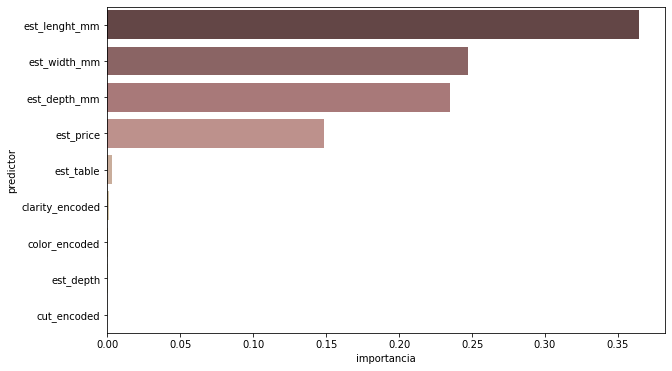

In [68]:
#Para poder apreciar visualmente la importancia predictora del modelo segun la importancia de cada una de las variables, ploteamos los resultados.
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="pink");
plt.show()

In [69]:
#Gardamos el csv con el total de resultados obtenidos en RL, DT y Random Forest. 
df_todos_resultados.to_csv("../datos/diamonds_rdos_totales.csv")